<img src="https://habrastorage.org/webt/ia/m9/zk/iam9zkyzqebnf_okxipihkgjwnw.jpeg" />
    
**<center>[mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course** </center><br>
Author: [Dmitry Sergeyev](https://github.com/DmitrySerg), Zeptolab. [mlcourse.ai](https://mlcourse.ai) is powered by [OpenDataScience (ods.ai)](https://ods.ai/) © 2017—2022

# <center>Assignment #9. Solution </center> <a class="tocSkip">
    
## <center> Times Series Analysis </center><a class="tocSkip">

In this assignment, we'll engineer some features and apply an ML model to a time series prediction task.  
    
### Your task is to:
 1. write code and perform computations in the cells below;
 2. choose answers in the [webform](https://forms.gle/K54dgp8VYZzrKxvF8).
 
*If you are sure that something is not 100% correct with the assignment/solution, please leave your feedback via the mentioned webform ↑*
    
-----

Importing necessary libraries

In [1]:
import random

random.seed(42)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler

# sharper plots
%config InlineBackend.figure_format = 'retina'


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

We will take real time-series data of total ads watched by hour in one of our games.

In [2]:
df = pd.read_csv(
    "../../_static/data/assignment9/ads_hour.csv", index_col=["Date"], parse_dates=["Date"]
)

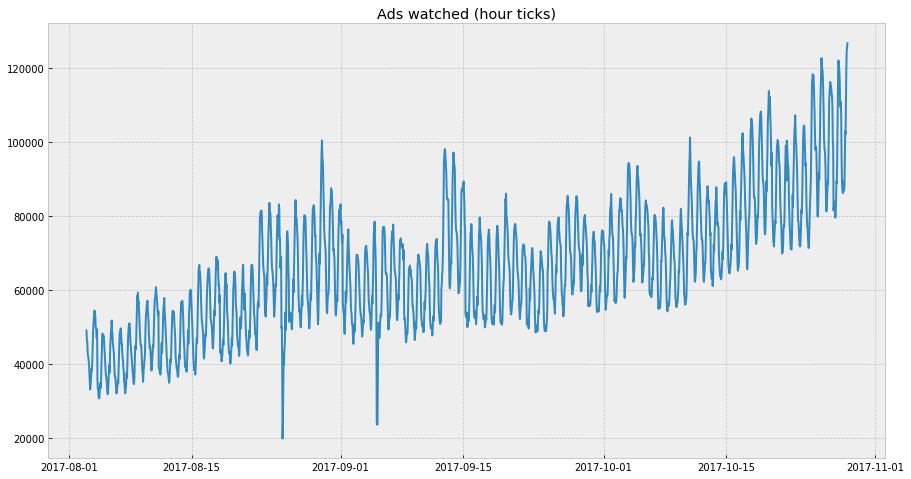

In [3]:
with plt.style.context("bmh"):
    plt.figure(figsize=(15, 8))
    plt.title("Ads watched (hour ticks)")
    plt.plot(df.ads);

We have everything you could ask for - trend, seasonality, even some outliers.

In this assignment we will concentrate on methods that have proven to be working in practice and can provide quality, comparable to ARIMA models. Namely, feature engineering, selecting and machine learning

But before digging into practice - a tiny bit of theory on how to create even more features. In this hometask we will be working with linear models. That means we assume there's a linear dependance between our target variable and the featureset, and we try to model that dependance. Now remember the `hour` variable we've created in the lecture? That variable showed on which hour a given observation arrived. Naturally, we expect hour plays a huge role, since at night the amount ofactive users who can watch ads drops significantly, at during the day it rises to its peak. However, if we use a single feature with number of an hour, linear models will not be able to model that dependance correctly. Why? Because look at the feature itself. It has values from $0$ to $23$ and even though we know that 0:00 is closer to 23:00 than, say, 20:00 to 23:00, the model will only see the numbers, not the logic behind them. And, of course, number 0 is way further from number 23 than number 20 from 23.  

How will we solve that problem? 

- First possible solution - let's get dummies and make 24 new columns out of one. Clear disadvantages - we explode the dimentionality of our data and lose any trace of the cyclical nature of hours.

- Second solution - sine/cosine transformation. To fully understand that approach, read [this short article](https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/). But in short - we want to encode hour feature with two new columns, which are sine and cosine transformations of "hour from midnight"

We will use the already familiar `prepareData` function with some modifications - sine/cosine transformation for `hour` and dummy transformation for `weekday` features

In [4]:
def prepareData(data, lag_start=5, lag_end=14, test_size=0.15):
    """
    series: pd.DataFrame
        dataframe with timeseries

    lag_start: int
        initial step back in time to slice target variable 
        example - lag_start = 1 means that the model 
                  will see yesterday's values to predict today

    lag_end: int
        final step back in time to slice target variable
        example - lag_end = 4 means that the model 
                  will see up to 4 days back in time to predict today

    test_size: float
        size of the test dataset after train/test split as percentage of dataset

    """
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # calculate test index start position to split data on train test
    test_index = int(len(data) * (1 - test_size))

    # adding lags of original time series data as features
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    # transforming df index to datetime and creating new variables
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday

    # since we will be using only linear models we need to get dummies from weekdays
    # to avoid imposing weird algebraic rules on day numbers
    data = pd.concat(
        [
            data.drop("weekday", axis=1),
            pd.get_dummies(data["weekday"], prefix="weekday"),
        ],
        axis=1,
    )

    # encode hour with sin/cos transformation
    # credits - https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
    data["sin_hour"] = np.sin(2 * np.pi * data["hour"] / 24)
    data["cos_hour"] = np.cos(2 * np.pi * data["hour"] / 24)
    data.drop(["hour"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # splitting whole dataset on train and test
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

Use the functions on original `df` to prepare datasets necessary for model training. Reserve 30% of data for testing, use initial lag 12 and final lag 48. This way the model will be able to make forecasts twelve steps ahead, having observed data from the previous 1.5 day. 

Scale the resulting datasets with the help of `StandardScaler` and create new variables - `X_train_scaled` and `X_test_scaled`. Don't forget that `scaler` should be trained on train set only to prevent information about future from leaking.

In [5]:
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit) (read-only in a JupyterBook, pls run jupyter-notebook to edit) (read-only in a JupyterBook, pls run jupyter-notebook to edit)
X_train, X_test, y_train, y_test = prepareData(
    df, test_size=0.3, lag_start=12, lag_end=48
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Now train a simple linear regression on scaled data:

In [6]:
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit) (read-only in a JupyterBook, pls run jupyter-notebook to edit) (read-only in a JupyterBook, pls run jupyter-notebook to edit)
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

Check the quality of the model on the training set with the help of cross-validation. To do so you need to create an  object-generator of time series cv folds with the help of  `TimeSeriesSplit`. Set the number of folds to be equal to 5. Then use `cross_val_score`, feeding it's `cv` parameter with the created generator. Quality metrics should be `neg_mean_absolute_error`.

Don't forget to take an average of the result and multiply it by -1.

In [7]:
tscv = TimeSeriesSplit(n_splits=5)
-1 * np.mean(
    cross_val_score(
        lr, X_train_scaled, y_train, cv=tscv, scoring="neg_mean_absolute_error"
    )
)

4490.0642733984405

**<font color='red'>Question 1.</font> What is the value of MAE on cross-validation?**
- 4876
- 41454725
- 4490 **<font color='red'>[+]</font>**
- 0.712

Now let's have a look at the forecast itself. We'll need `plotModelResults` function. 

In [8]:
def plotModelResults(
    model, df_train, df_test, y_train, y_test, plot_intervals=False, scale=1.96, cv=tscv
):
    """
    Plots modelled vs fact values
    
    model: fitted model 
    
    df_train, df_test: splitted featuresets
    
    y_train, y_test: targets
    
    plot_intervals: bool, if True, plot prediction intervals
    
    scale: float, sets the width of the intervals
    
    cv: cross validation method, needed for intervals
    
    """
    # making predictions for test
    prediction = model.predict(df_test)

    plt.figure(figsize=(20, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        # calculate cv scores
        cv = cross_val_score(
            model, df_train, y_train, cv=cv, scoring="neg_mean_squared_error"
        )

        # calculate cv error deviation
        deviation = np.sqrt(cv.std())

        # calculate lower and upper intervals
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

    # calculate overall quality on test set
    mae = mean_absolute_error(prediction, y_test)
    mape = mean_absolute_percentage_error(prediction, y_test)
    plt.title("MAE {}, MAPE {}%".format(round(mae), round(mape, 2)))
    plt.legend(loc="best")
    plt.grid(True);

For model coefficients visualization use the following functions:

In [9]:
def getCoefficients(model):
    """Returns sorted coefficient values of the model"""
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    return coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)


def plotCoefficients(model):
    """Plots sorted coefficient values of the model"""
    coefs = getCoefficients(model)

    plt.figure(figsize=(20, 7))
    coefs.coef.plot(kind="bar")
    plt.grid(True, axis="y")
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles="dashed")
    plt.show()

Check the model results and plot the coefficients

In [10]:
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit) (read-only in a JupyterBook, pls run jupyter-notebook to edit) (read-only in a JupyterBook, pls run jupyter-notebook to edit)

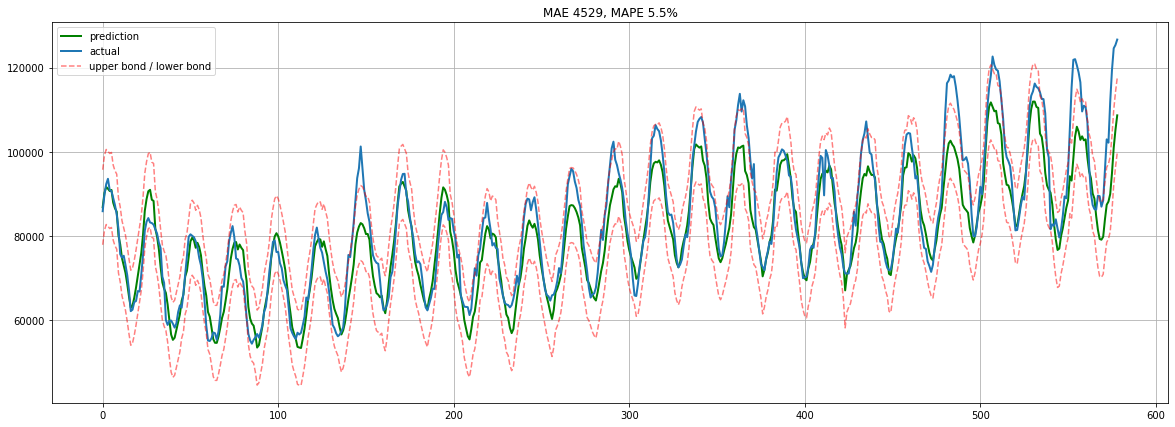

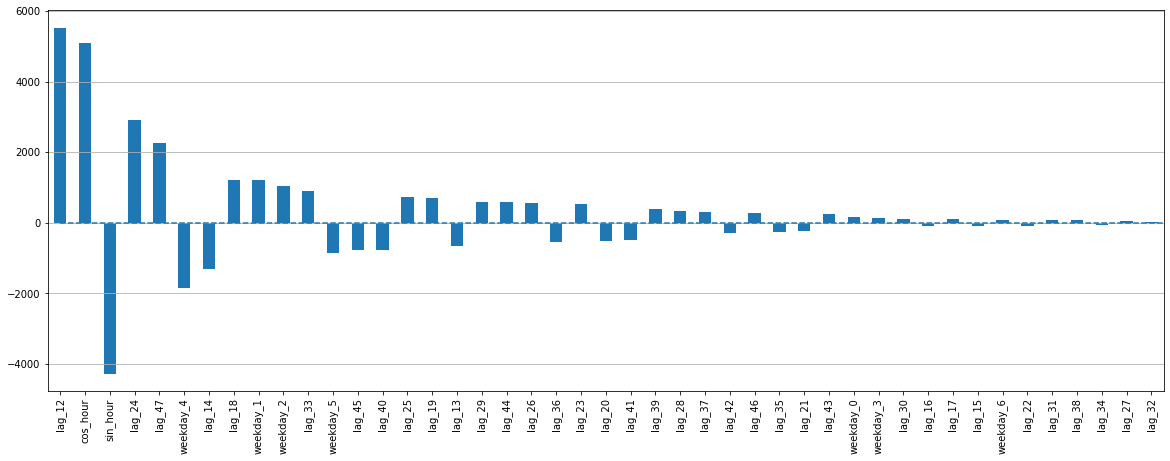

In [11]:
plotModelResults(
    lr, X_train_scaled, X_test_scaled, y_train, y_test, plot_intervals=True
)
plotCoefficients(lr)

Wonderful, the intervals are plotted, forecast quality is great and everything seems to be fine, but...We might be having too many variables in our model and, possibly, some of them are not that important and can be dropped, reducing the dimentionality of data and reducing the chances of overfit. To make sure we have extra features, plot a heatmape of `X_train` data correlations with the help of `heatmap` function from `seaborn` library:

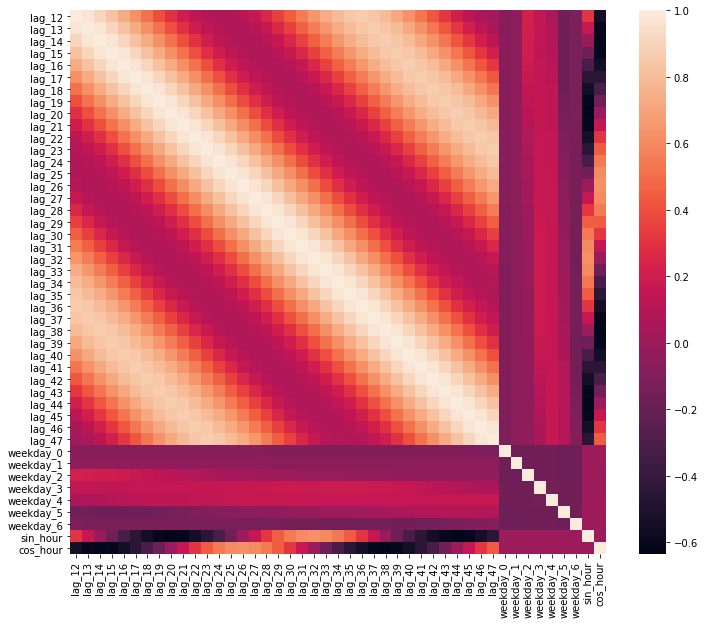

In [12]:
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr());

Indeed, features are highly  correlated and you can even observe some kind of "seasonality" in those correlations on each 24-th lag. Let's try to add regularization to our models and remove some features. 

Train Lasso regression on cross-validation (`LassoCV`) again feeding the `cv` parameter with the created generator-object. 

Plot the forecast of the model and notice that the error on test dataset has not increased significantly 

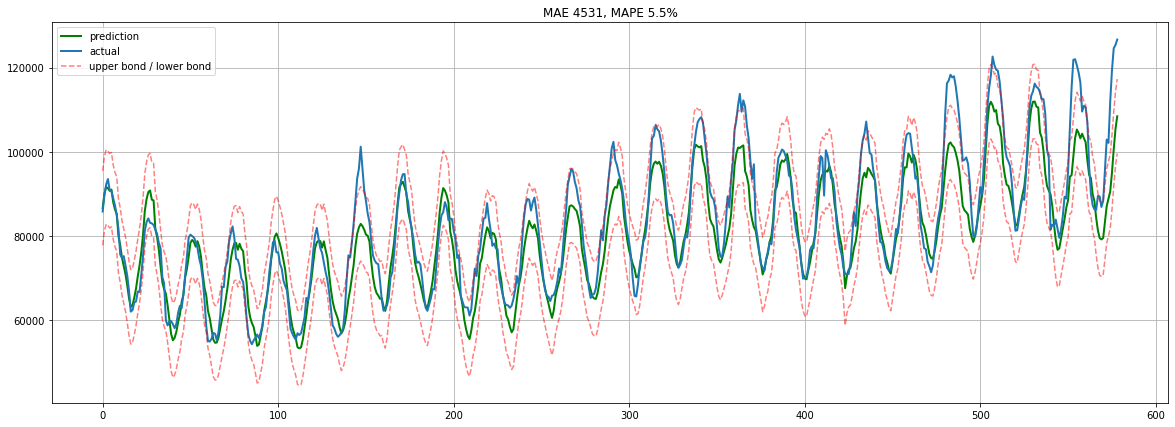

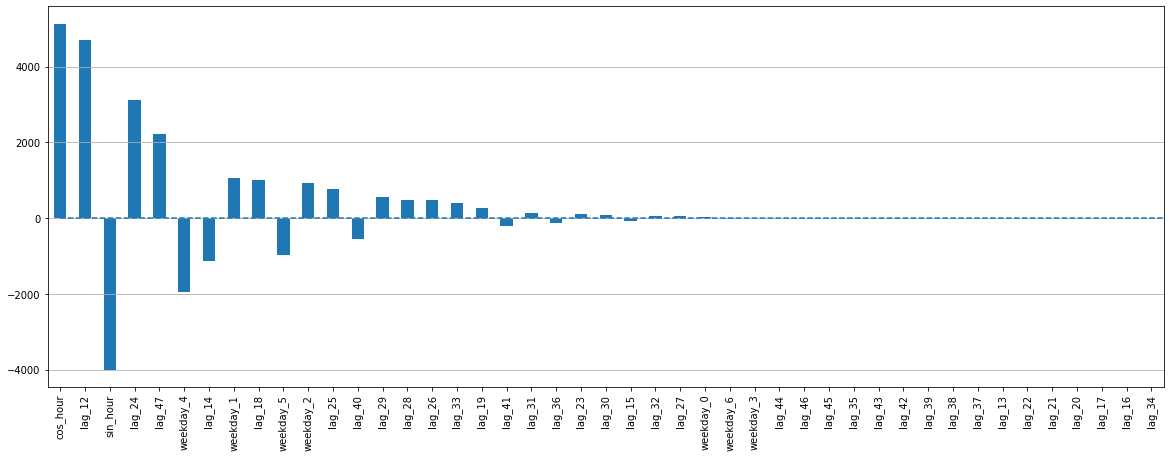

In [13]:
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit) (read-only in a JupyterBook, pls run jupyter-notebook to edit) (read-only in a JupyterBook, pls run jupyter-notebook to edit)
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)
plotModelResults(
    lasso, X_train_scaled, X_test_scaled, y_train, y_test, plot_intervals=True
)
plotCoefficients(lasso)

Perfect, we are still having practically the same model quality, while having less features. Use the function `getCoefficients` and find, how many features are now dropped (coefficient equals zero).

In [14]:
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit) (read-only in a JupyterBook, pls run jupyter-notebook to edit) (read-only in a JupyterBook, pls run jupyter-notebook to edit)
getCoefficients(lasso)

,coef
cos_hour,5130.599909
lag_12,4702.879114
sin_hour,-4002.881516
lag_24,3124.229452
lag_47,2214.624814
weekday_4,-1955.972849
lag_14,-1128.727385
weekday_1,1063.876179
lag_18,1007.208450
weekday_5,-979.154157


In [15]:
(lasso.coef_ == 0).sum()

17

**<font color='red'>Question 2.</font> How many coefficients of Lasso model equal zero? (with 6 digit precision)?**

- 11
- 12
- 15
- 17 **<font color='red'>[+]</font>**

Alright, we have some features dropped. But what if we want to go further and transform our linear-dependant features into more compact representation? To do so we'll use principal component analysis.

In [16]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline


def plotPCA(pca):
    """
    Plots accumulated percentage of explained variance by component
    
    pca: fitted PCA object
    """
    components = range(1, pca.n_components_ + 1)
    variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4) * 100)
    plt.figure(figsize=(20, 10))
    plt.bar(components, variance)

    # additionally mark the level of 95% of explained variance
    plt.hlines(y=95, xmin=0, xmax=len(components), linestyles="dashed", colors="red")

    plt.xlabel("PCA components")
    plt.ylabel("variance")
    plt.xticks(components)
    plt.show()

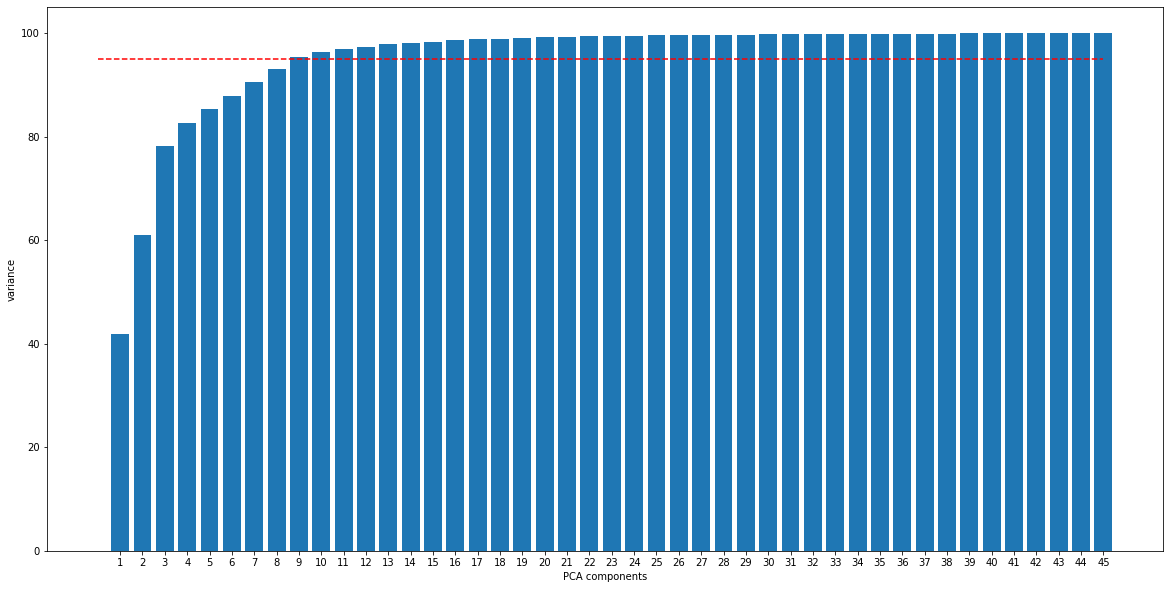

In [17]:
# Create PCA object: pca
pca = PCA()

# Train PCA on scaled data
pca.fit(X_train_scaled)

# plot explained variance
plotPCA(pca)

**<font color='red'>Question 3.</font> What is the minimal number of components needed to explain _at least_ 95% of variance of the train dataset?**

- 5
- 7
- 9 **<font color='red'>[+]</font>**
- 12

Create the `pca` object once again, this time setting inside it the optimal number of components (explaining at least 95% of variance). After that create two new variables - `pca_features_train` and `pca_features_test`, assigning to them pca-transformed scaled datasets.

In [18]:
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit) (read-only in a JupyterBook, pls run jupyter-notebook to edit) (read-only in a JupyterBook, pls run jupyter-notebook to edit)
pca = PCA(n_components=9)
pca_features_train = pca.fit_transform(X_train_scaled)
pca_features_test = pca.transform(X_test_scaled)

Now train linear regression on pca features and plot its forecast.

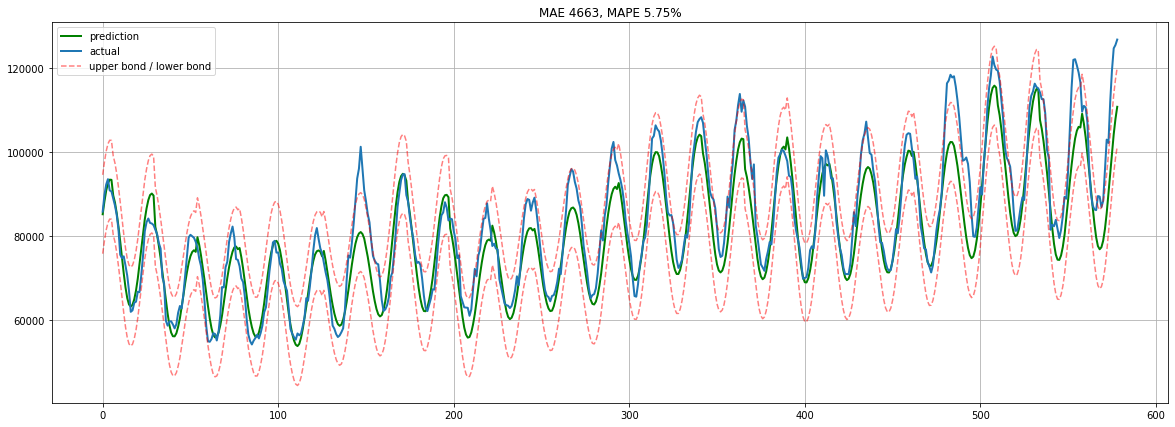

In [19]:
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit) (read-only in a JupyterBook, pls run jupyter-notebook to edit) (read-only in a JupyterBook, pls run jupyter-notebook to edit)
lr = LinearRegression()
lr.fit(pca_features_train, y_train)
plotModelResults(
    lr, pca_features_train, pca_features_test, y_train, y_test, plot_intervals=True
)

**<font color='red'>Question 4.</font> What is the MAE of linear regression, trained on pca-transformed features?**
- 5140
- 4917
- 6719
- 4663 **<font color='red'>[+]</font>**